<a href="https://colab.research.google.com/github/dbright123/Dbot-Advance/blob/main/lstm_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd





In [ ]:
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

trade_active = mt5.initialize()

print(trade_active)

if not trade_active:
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')
    mt5.shutdown()

else:
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())
    print("\n")
    print(mt5.symbols_total())

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4200
True
{'login': 63134054, 'trade_mode': 2, 'leverage': 200, 'limit_orders': 500, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 50.12, 'credit': 13.06, 'profit': 0.0, 'equity': 63.18, 'margin': 0.0, 'margin_free': 63.18, 'margin_level': 0.0, 'margin_so_call': 25.0, 'margin_so_so': 15.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'Bright Idowu ', 'server': 'OctaFX-Real', 'currency': 'USD', 'company': 'Octa Markets Incorporated'}


{'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': False, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': True, 'build': 5370, 'maxbars': 100000000, 'codepage': 0, 'ping_last': 1988

In [ ]:
account = mt5.account_info()
terminal = mt5.terminal_info()

print(account.equity)

if(terminal.connected == True or terminal.trade_allowed == True):
    print("AI is successfully functional")
else:
    print("Please make sure metatrade 5 has internet and algo Trade is Turn On")

63.18
AI is successfully functional


In [ ]:
t_s = "BTCUSD"
market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_M5, 0, 10000000)
#display(market)
print(market.shape)

print(t_s)




(722728,)
BTCUSD


In [ ]:
market

array([(1311242400, 1.3690000e+01, 1.378000e+01, 1.340000e+01, 1.361000e+01,   69,    0, 0),
       (1311328800, 1.3610000e+01, 1.381000e+01, 1.345000e+01, 1.370000e+01,   64,    0, 0),
       (1311415200, 1.3700000e+01, 1.376000e+01, 1.351000e+01, 1.368000e+01,   49,    0, 0),
       ...,
       (1762898100, 1.0328383e+05, 1.033055e+05, 1.030590e+05, 1.030890e+05, 1725, 2520, 0),
       (1762898400, 1.0309000e+05, 1.030945e+05, 1.029350e+05, 1.030000e+05, 1793, 2527, 0),
       (1762898700, 1.0299400e+05, 1.030400e+05, 1.028489e+05, 1.028655e+05, 1276, 2521, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

In [ ]:
data = []
for i in range(len(market)):
    data.append([market[i][0],market[i][1],market[i][2],market[i][3],market[i][4],market[i][5]])
df = pd.DataFrame(data, columns=["time","open", "high","low", "close","volume"])
df.to_csv("Generated"+t_s+" dbot.csv", index=False)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
print(tf.__version__)


2.19.0


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scaler3d2d import preprocess_and_save_scalers,transform_data, inverse_transform_data,create_sequences



In [3]:
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt



from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import keras

In [4]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import math

In [12]:
window_size = 60         # length of input sequence for model (e.g., 60 timesteps)
lookahead = 3            # how many future closes to check to form the label
threshold = 0.0015       # minimal relative move (e.g., 0.15%) to consider up/down (set 0 to disable)
train_frac = 0.7         # chronological split: train | val | test
val_frac = 0.15
test_frac = 0.15

In [5]:
t_symbol = ["GBPUSD"]

In [6]:


def engineer_features(df):
    df['time'] = pd.to_datetime(df['time'], unit='s', errors='coerce')
    df['month'] = df['time'].dt.month

    # Extract day of the month (1-31)
    df['day'] = df['time'].dt.day


    # --- New Additions ---
    # Extract hour (0-23)
    df['hour'] = df['time'].dt.hour

    # Extract minute (0-59)
    df['minute'] = df['time'].dt.minute

    # --- End of New Additions ---

    # 3. Remove the original 'time' column
    df = df.drop(columns=['time'])
    # --- Clean up and drop NaNs (first ~200 rows) ---
    df = df.dropna().reset_index(drop=True)

    return df

# Usage:
# df = pd.read_csv('btcusd_5min.csv')
# df = engineer_features_5min_btc(df)

In [7]:
n = 0
m_label = "Generated"+t_symbol[n]
#pd.set_option('display.float_format', '{:.20f}'.format)

train_df = pd.read_csv(m_label+ " dbot.csv")[['time','open','high','low','close']]
train_df = engineer_features(train_df)
train_df

,open,high,low,close,month,day,hour,minute
0,1.53700,1.54450,1.52900,1.53380,5,12,0,0
1,1.53280,1.53600,1.51800,1.52250,5,13,0,0
2,1.52280,1.54150,1.52000,1.53870,5,14,0,0
3,1.53650,1.54600,1.53090,1.53550,5,17,0,0
4,1.53500,1.53800,1.52370,1.53650,5,18,0,0
...,...,...,...,...,...,...,...,...
666584,1.31224,1.31277,1.31204,1.31249,11,12,12,45
666585,1.31252,1.31252,1.31171,1.31181,11,12,13,0
666586,1.31182,1.31275,1.31151,1.31263,11,12,13,15
666587,1.31264,1.31297,1.31224,1.31233,11,12,13,30


In [8]:


max_val = train_df.max()
print(max_val)
train_df = train_df/max_val
#train_df = engineer_features_5min_btc(train_df)[10:]

open       2.1142
high       2.1161
low        2.1129
close      2.1144
month     12.0000
day       31.0000
hour      23.0000
minute    45.0000
dtype: float64


In [9]:
train_df

,open,high,low,close,month,day,hour,minute
0,0.726989,0.729880,0.723650,0.725407,0.416667,0.387097,0.000000,0.000000
1,0.725002,0.725864,0.718444,0.720062,0.416667,0.419355,0.000000,0.000000
2,0.720272,0.728463,0.719390,0.727724,0.416667,0.451613,0.000000,0.000000
3,0.726752,0.730589,0.724549,0.726211,0.416667,0.548387,0.000000,0.000000
4,0.726043,0.726809,0.721142,0.726684,0.416667,0.580645,0.000000,0.000000
...,...,...,...,...,...,...,...,...
666584,0.620679,0.620372,0.620966,0.620739,0.916667,0.387097,0.521739,1.000000
666585,0.620812,0.620254,0.620810,0.620417,0.916667,0.387097,0.565217,0.000000
666586,0.620481,0.620363,0.620716,0.620805,0.916667,0.387097,0.565217,0.333333
666587,0.620868,0.620467,0.621061,0.620663,0.916667,0.387097,0.565217,0.666667


In [10]:

#train_df_test = train_dfs_test[n]
print(m_label)
SEQ_LEN = 120 # length of input sequence (timesteps). Typical choices: 30, 60, 90
n_rows, n_features = train_df.values.shape


X, y = create_sequences(train_df.values, SEQ_LEN, 3, 3 )
train_df = None
n_samples = X.shape[0]
#print(X[-1])
print(y[-1])

GeneratedGBPUSD
[0.62080496 0.62066307 0.62084752]


In [13]:
# -----------------------
# Chronological split: train / val / test
# -----------------------
n = len(X)
train_end = int(math.floor(n * train_frac))
val_end = train_end + int(math.floor(n * val_frac))

X_train = X[:train_end]
y_train = y[:train_end]
X_val = X[train_end:val_end]
y_val = y[train_end:val_end]
X_test = X[val_end:]
y_test = y[val_end:]

X = None
y = None

In [19]:

seq_len = X_train.shape[1]
n_features = X_train.shape[2]
output_dim = y_train.shape[1]

i = Input(shape=(seq_len, n_features))

X = Bidirectional(LSTM(128, return_sequences=True))(i)
X = Bidirectional(LSTM(64, return_sequences=True))(X)
X = Bidirectional(LSTM(32))(X)
X = Dropout(0.3)(X)
X = Dense(64)(X)
X = Dense(output_dim)(X)

model = Model(i, X)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 120, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 120, 256)       │       140,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 120, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 350,211 (1.34 MB)

 Trainable params: 350,211 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:

es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(m_label + 'lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=2)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae',tf.keras.metrics.RootMeanSquaredError(),'mape','msle'])
r = model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  batch_size=4096,
  callbacks=[es, rlr, mc ],
  verbose=1

)

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - loss: 0.0574 - mae: 0.1573 - mape: 20.5932 - msle: 0.0231 - root_mean_squared_error: 0.2181
Epoch 1: val_loss improved from inf to 0.00022, saving model to GeneratedGBPUSDlstm_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 94s 746ms/step - loss: 0.0571 - mae: 0.1568 - mape: 20.5214 - msle: 0.0230 - root_mean_squared_error: 0.2174 - val_loss: 2.2118e-04 - val_mae: 0.0140 - val_mape: 2.2562 - val_msle: 8.5561e-05 - val_root_mean_squared_error: 0.0149 - learning_rate: 0.0010
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - loss: 0.0045 - mae: 0.0529 - mape: 6.8926 - msle: 0.0014 - root_mean_squared_error: 0.0669
Epoch 2: val_loss improved from 0.00022 to 0.00002, saving model to GeneratedGBPUSDlstm_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 86s 751ms/step - loss: 0.0045 - mae: 0.0529 - mape: 6.8896 - msle: 0.0014 - root_mean_squared_error: 0.0669 - val_loss: 1.8646e-05 - val_mae: 0.0035 - val_mape: 0.5670 - val_msle: 7.0463e-06 - val_

KeyboardInterrupt: 

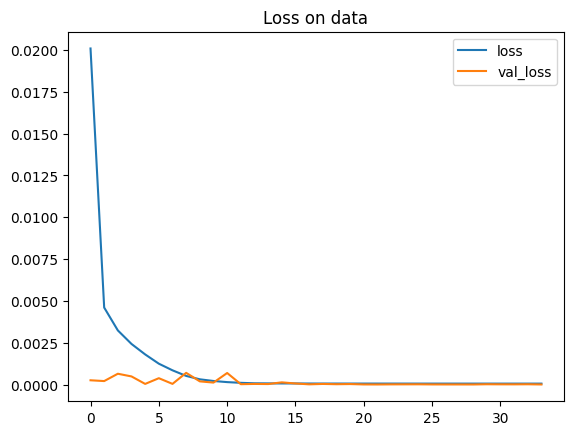

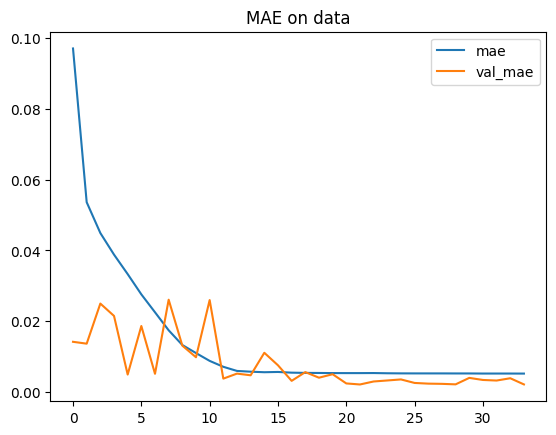

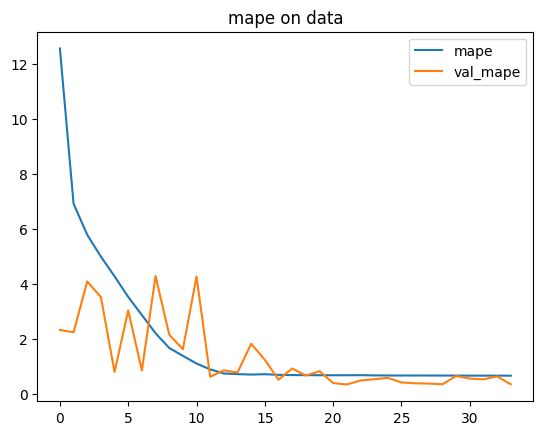

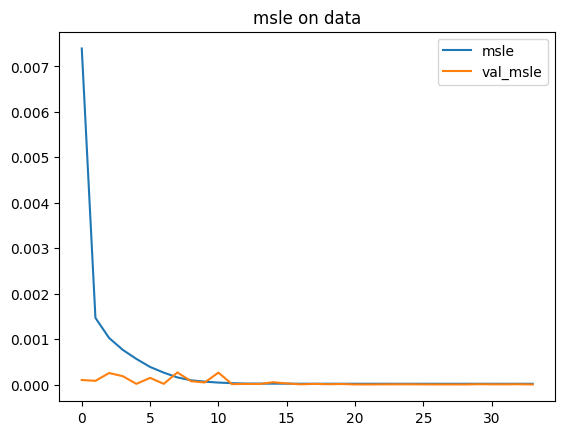

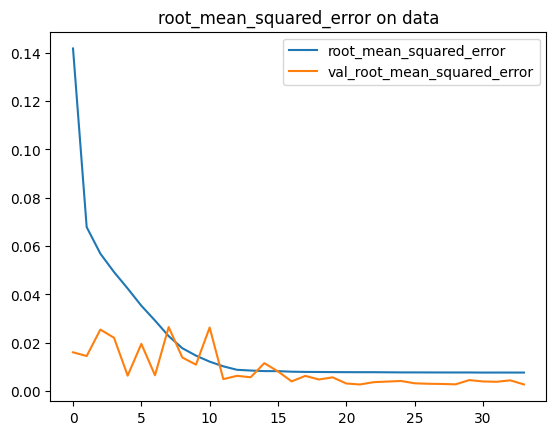

In [13]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

plt.title("MAE on data")
plt.plot(r.history['mae'], label="mae")
plt.plot(r.history['val_mae'], label="val_mae")
plt.legend()
plt.show()

plt.title("mape on data")
plt.plot(r.history['mape'], label="mape")
plt.plot(r.history['val_mape'], label="val_mape")
plt.legend()
plt.show()

plt.title("msle on data")
plt.plot(r.history['msle'], label="msle")
plt.plot(r.history['val_msle'], label="val_msle")
plt.legend()
plt.show()

plt.title("root_mean_squared_error on data")
plt.plot(r.history['root_mean_squared_error'], label="root_mean_squared_error")
plt.plot(r.history['val_root_mean_squared_error'], label="val_root_mean_squared_error")
plt.legend()
plt.show()




In [14]:
m_label = "GeneratedGBPUSD"
best_model = load_model(m_label + 'lstm_best.keras')

In [15]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 90, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 90, 256)        │       142,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 90, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,056,779 (4.03 MB)

 Trainable params: 352,259 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 704,520 (2.69 MB)

In [16]:
y_pred = best_model.predict(X_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [17]:
print(y_pred.shape)

(2200, 3)


In [18]:
#_,y_test = inverse_transform_data(scaled_y=y_test)
#_,y_pred = inverse_transform_data(scaled_y=y_pred)
print(y_test, " comparing to ", y_pred)

[[0.62788971 0.6280174  0.62770526]
 [0.6280174  0.62770526 0.62770053]
 [0.62770526 0.62770053 0.62780458]
 ...
 [0.62073874 0.62041714 0.62080496]
 [0.62041714 0.62080496 0.62066307]
 [0.62080496 0.62066307 0.62084752]]  comparing to  [[0.6259484  0.62582946 0.62628984]
 [0.6256639  0.6253761  0.62615263]
 [0.62572557 0.62543666 0.6263976 ]
 ...
 [0.61910653 0.6188447  0.6194596 ]
 [0.6191498  0.61887634 0.619689  ]
 [0.6189586  0.6188683  0.61977464]]


In [19]:
# 1. Calculate the error (the gap between actual and predicted)
error = y_test - y_pred

# 2. Calculate the average gap (the bias)
average_gap = np.mean(error)
print(f"Average Gap (Bias): {average_gap:.7f}")

# 3. Add the average gap to your predictions to create a corrected version
y_pred_corrected = y_pred + average_gap

# --- Verification ---
# Let's check the first predicted value vs. the first actual value
print("\n--- Example of Correction ---")
print(f"Original Prediction: {y_pred[0, 0]:.7f}")
print(f"Corrected Prediction: {y_pred_corrected[0, 0]:.7f}")
print(f"Actual Value:        {y_test[0, 0]:.7f}")



Average Gap (Bias): 0.0016362

--- Example of Correction ---
Original Prediction: 0.6259484
Corrected Prediction: 0.6275846
Actual Value:        0.6278897


In [20]:
print("R^2 value for ", m_label)
print(r2_score(y_test, y_pred))
print(r2_score(y_test, y_pred_corrected))

R^2 value for  GeneratedGBPUSD
0.8540973668081034
0.9324644802575247


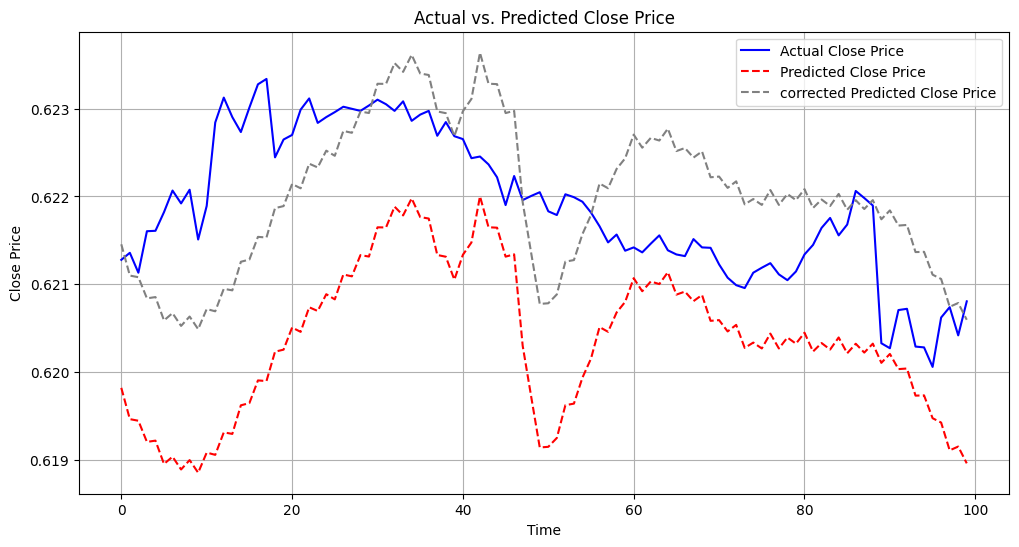

In [21]:

plt.figure(figsize=(12, 6))
plt.plot(y_test[-100:, 0], label='Actual Close Price', color='blue')
plt.plot(y_pred[-100:, 0], label='Predicted Close Price', color='red', linestyle='--')
plt.plot(y_pred_corrected[-100:, 0], label='corrected Predicted Close Price', color='gray', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()


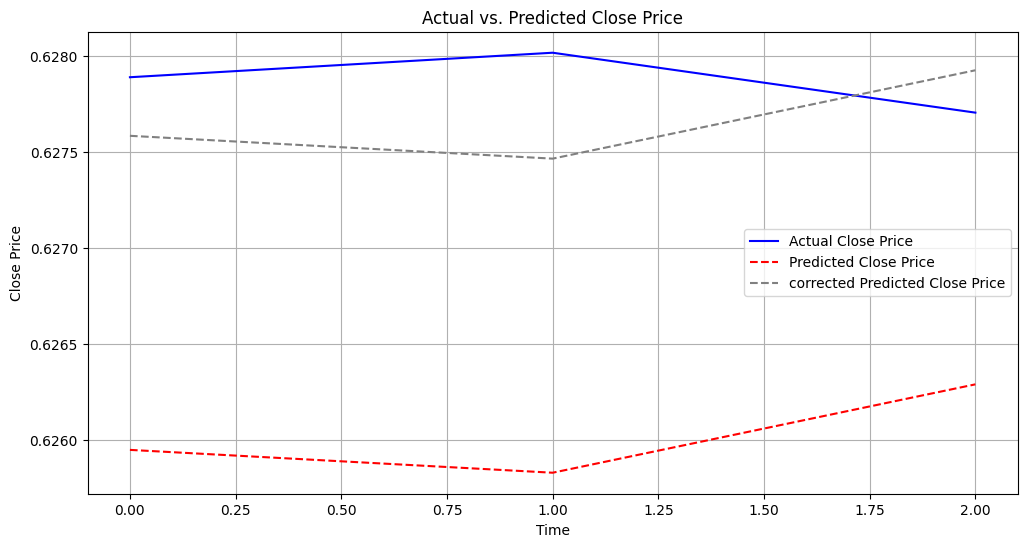

In [22]:

plt.figure(figsize=(12, 6))
plt.plot(y_test[0, :], label='Actual Close Price', color='blue')
plt.plot(y_pred[0, :], label='Predicted Close Price', color='red', linestyle='--')
plt.plot(y_pred_corrected[0, :], label='corrected Predicted Close Price', color='gray', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()

In [14]:
def label_trends(data):
    """
    Labels time-series data based on trend direction.

    The data is assumed to have 3 time steps (e.g., price1, price2, price3).
    - 1: Uptrend (price1 < price2 < price3)
    - 2: Downtrend (price1 > price2 > price3)
    - 0: Neutral (all other cases)

    Args:
        data (np.ndarray): A 2D NumPy array with shape (n_samples, 3).

    Returns:
        np.ndarray: A 1D NumPy array with shape (n_samples,) containing the
                    corresponding labels (0, 1, or 2).
    """

    # Ensure data is a 2D array, even if a single (3,) sample is passed
    if data.ndim == 1:
        if data.shape[0] != 3:
            raise ValueError(f"Input array has shape {data.shape} but expected (3,) or (n, 3)")
        # Reshape single sample to (1, 3) for consistent processing
        data = data.reshape(1, 3)

    # Extract the three price points for all samples
    price1 = data[:, 0]
    price2 = data[:, 1]
    price3 = data[:, 2]

    # Define the conditions for uptrend and downtrend
    # We use '&' for element-wise logical AND
    is_uptrend = (price1 < price2) & (price2 < price3)
    is_downtrend = (price1 > price2) & (price2 > price3)

    # Use np.select to efficiently apply the labels
    # 1. List of conditions
    conditions = [
        is_uptrend,
        is_downtrend
    ]

    # 2. List of choices corresponding to each condition
    choices = [
        1,  # Label for uptrend
        2   # Label for downtrend
    ]

    # 3. Default value if no condition is met (Neutral)
    default_label = 0

    # np.select evaluates conditions in order and picks the first one that is True
    labeled_data = np.select(conditions, choices, default=default_label)

    return labeled_data

In [15]:

# 2. Apply the labeling function to "override" the data
y_train = label_trends(y_train)
y_val = label_trends(y_val)
y_test = label_trends(y_test)

print("--- Labeled Data ---")
print("Mapping: 1 = Uptrend, 2 = Downtrend, 0 = Neutral\n")
print(f"y_train_labeled (shape {y_train.shape}):\n{y_train}\n")
print(f"y_val_labeled (shape {y_val.shape}):\n{y_val}\n")
print(f"y_test_labeled (shape {y_test.shape}):\n{y_test}\n")


--- Labeled Data ---
Mapping: 1 = Uptrend, 2 = Downtrend, 0 = Neutral

y_train_labeled (shape (466526,)):
[0 0 0 ... 1 0 2]

y_val_labeled (shape (99970,)):
[2 0 0 ... 2 0 0]

y_test_labeled (shape (99971,)):
[0 1 1 ... 0 0 0]



In [17]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): w for c, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.580780655168722), 1: np.float64(1.5481817759459477), 2: np.float64(1.5816263569360536)}


In [25]:

seq_len = X_train.shape[1]
n_features = X_train.shape[2]

output_dim = 3

i = Input(shape=(seq_len, n_features))

X = Bidirectional(LSTM(64, return_sequences=True))(i)
X= BatchNormalization()(X)
X = Dropout(0.3)(X)
X = Bidirectional(LSTM(64, return_sequences=True))(X)
X= BatchNormalization()(X)
X = Dropout(0.3)(X)
X = Bidirectional(LSTM(32))(X)
X= BatchNormalization()(X)
X = Dropout(0.3)(X)

X = Dense(64, activation='relu')(X)
X = Dense(output_dim, activation='softmax')(X)

model = Model(i, X)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 120, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 120, 128)       │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 120, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 120, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 120, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,043 (715.01 KB)

 Trainable params: 182,403 (712.51 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:

es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(m_label + 'lstm_best_classify.keras', monitor='val_loss', save_best_only=True, verbose=2)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
r = model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  batch_size=4096,
  callbacks=[es, rlr, mc ],
  class_weight=class_weight_dict,
  verbose=1

)

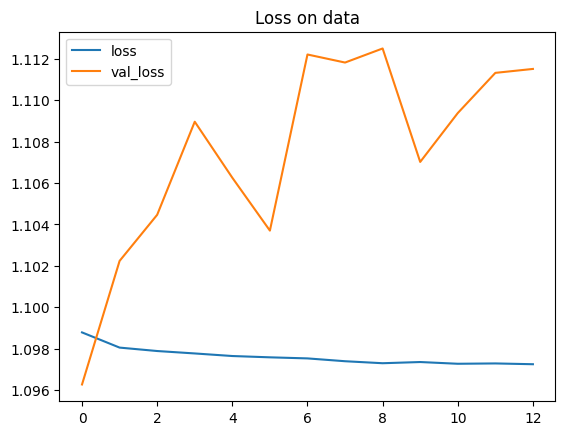

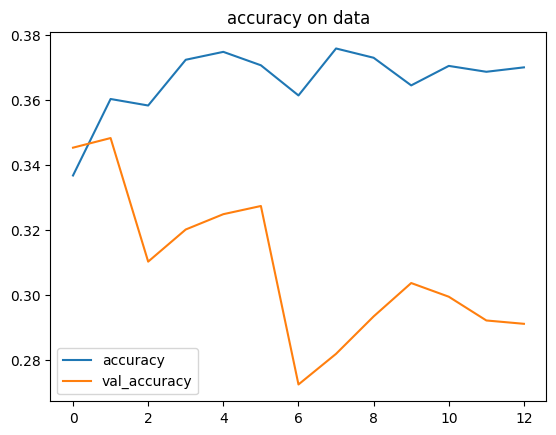

In [23]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

plt.title("accuracy on data")
plt.plot(r.history['accuracy'], label="accuracy")
plt.plot(r.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

In [ ]:
# -----------------------
# Evaluation & Metrics (probabilities, F1 micro & macro, confusion matrix)
# -----------------------
y_proba_test = model.predict(X_test)   # probabilities
y_pred_test = np.argmax(y_proba_test, axis=1)

acc = np.mean(y_pred_test == y_test)
f1_micro = f1_score(y_test, y_pred_test, average='micro')
f1_macro = f1_score(y_test, y_pred_test, average='macro')

print(f"Test accuracy: {acc:.4f}")
print(f"F1 micro: {f1_micro:.4f}")
print(f"F1 macro: {f1_macro:.4f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_test, target_names=['neutral(0)', 'up(1)', 'down(2)']))

cm = confusion_matrix(y_test, y_pred_test, labels=[0,1,2])
print("Confusion matrix (rows = true, cols = pred):\n", cm)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(['neutral(0)','up(1)','down(2)'])
ax.set_yticklabels(['neutral(0)','up(1)','down(2)'])
# Annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center")
plt.tight_layout()
plt.show()

# -----------------------
# Useful: examine probabilities to set custom decision rules
# -----------------------
# Example: show average confidence for correct vs incorrect predictions
conf_correct = y_proba_test[y_pred_test == y_test, :]
conf_incorrect = y_proba_test[y_pred_test != y_test, :]
print("Avg max-prob when correct:", np.mean(np.max(conf_correct, axis=1)) if len(conf_correct)>0 else None)
print("Avg max-prob when incorrect:", np.mean(np.max(conf_incorrect, axis=1)) if len(conf_incorrect)>0 else None)
